# SVI & COVID - SAN ANTONIO

## Summary

The CDC's social vulnerability index (SVI) is a scale that predicts the vulnerability of a population in the event of an emergency or natural disaster. COVID is the first global pandemic since the development of this measure. We will evaluate the association between SVI score and COVID case count in San Antonio, Texas. Features from this measure will be incorporated into a predictive model that can be used to guide recovery resource prioritization.



**Goals**      
1. Evaluate association between SVI score and COVID case count in San Antonio, TX     
2. Build a model based SVI score component features that can predict COVID cases by census tract within San Antonio, TX
3. Complete same evaluation and models for Dallas
4. Is there a difference between San Antonio and Dallas results?


### Problem Statement

Background
The SVI (Social Vulnerability Index) was developed to help city governments and first responders predict areas that are particularly vulnerable in emergency situations so that resources can be prioritized to help areas at high risk (Citation CDC Website). The CDC’s Social Vulnerability Index (CDC SVI) uses 15 U.S. census variables to classify census tracts with a composite score between 0 and 1 (lower scores = less vulnerability, higher score = greater vulnerability. This socre is calculated by first ranking every census tract, in every country, in every state, in the United States. Those ranked tracks are then broken up to 4 themes (socioeconomic status, household composition and disability, minority status and language, household type and transportation) and reclassified. This overall score is then tallied by summing the themed percentiles and ranked on a score between 0 and 1.

While SVI was designed to help city goverments repsond to emergency situations, the efficacy of the systems has never been tested on in response to a global pandemic. COVID-19 is the disease caused by a new coronavirus called SARS-CoV-2. WHO first learned of this new virus on 31 December 2019, following a report of a cluster of cases of ‘viral pneumonia’ in Wuhan, People’s Republic of China. (Citation WHO). As of 9 December 2020, more than 68.4 million cases have been confirmed, with more than 1.56 million deaths attributed to COVID-19.




### Work Plan

*Now that you have a clear idea of what you are trying to accomplish, you need to find a data source. Think of this as working through a maze forwards and backwards at the same time. At the start you have any number of data sets available to work with (and the whole Internet to search and scrape), and at the end is the hypothetical data set that would answer your question immediately if you had it.*

- What data, if you had it, would solve your problem right away?
    - Cases count per 100K by census tract nationally would be ideal
- What data do you have access to?
    - Have SVI from CDC by census track
    - Have Bexar county case count per 100K by zip code for single date 12/8/20
- What additional data would be good to have?
    - be great to have more historical data
- What data would be impossible to collect?
    - due to privacy/panic concerns case data at the census tract level is not being published for open access
- What are the best proxies you can find for unavailable or impossible data?
    - find a way to translate from census tract to zip code
- What are the legal or ethical issues you might run into if you were to try to collect all of the types of data you would like to work with?
    - considered web scraping for zip code level data where specific information is not available
    - likely better to hard code existing data that is publicly available

*Of course you need to make a plan to turn your data into the solutions you need. Think of what type of problem this is, what models are commonly used for those types of problems, what types of data those models require and special considerations that may need to be made. Do your homework and find out what approaches other people are using on similar tasks.*

- What ML paradigm are you working in? (Classification, Regression, Clustering, etc)
    - Regression
- What models are commonly used in this task?
    - Linear Regression, LassoLars, Polynomial Features, Tweedie Regressor
* What other solutions are being tried in this field?
* What special considerations need to be taken when dealing with these models? (i.e., imbalanced classes, text preprocessing, data leakage, etc)
* How will you know that your models work?
* How will you recognize and diagnose cases where the predictions are incorrect?

## Imports


In [1]:
import pandas as pd
import seaborn as sns
import wrangle
import explore
import model_MAE

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# Classfication Modeling:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import model_classification

from math import sqrt
from scipy import stats

# Acquire & Prepare

- SVI data from the CDC's website
- downloaded COVID data for San Antonio and Dallas from the cities respective COVID data web portals
- HUD crosswalk provided a guide to transform the data
    - complicated because of overlap in census tracts and zip codes
    - found the Zip code that accounted for the highest percentage of addresses within the tract and assigned that as the sole Zip code for the tract
    - the ratio of addresses for the census tract was then used to calculate a cases per 100K measure for each tract 
- selected 29 features and renamed for clarity
- verified no null values to address
- military bases were removed from the data frame
- raw SVI score binned
    - bin_svi column = text label (low, low-mod, mod-high, high)
    - rank_svi column = numeric representation of SVI (1 representing a high score, 4 representing a low score)
- numeric columns with values greater than 4 were scaled using sklearn's MinMaxScaler
- six data frames returned at then end of wrangle including *train_explore* for exploration and individual scaled data frames for modeling  *X_train_scaled, y_train, X_test_scaled, y_test*.

In [2]:
df, train_exp, X_train_scaled, y_train, X_test_scaled, y_test = wrangle.wrangle_data()

Acquire: compiling raw data files...
Acquire: Completed!
Prepare: preparing data files...
Prepare: Completed!
(289, 40) (73, 40)


# Explore

Exploration focuses on answering questions regarding the relationship between the CDC's range category SVI score and cases of COVID-19 per 100k.

- Visualize cases per 100K by binned SVI value
    - Appear to be distinct
    - Will conduct parametric ANOCA (Kruskal) test to confirm
- Verify raw SVI score relationship to cases per 100K
    - will conduct Pearson's R correlation test
- Explore distribution of casses per 100K with SVI score
- Explore distribution of flags by SVI score


## Hypothesis Testing

### Question One: Is there a correlation between the CDC's Range Category SVI Score and COVID-19 Infection Cases per 100k Individuals?

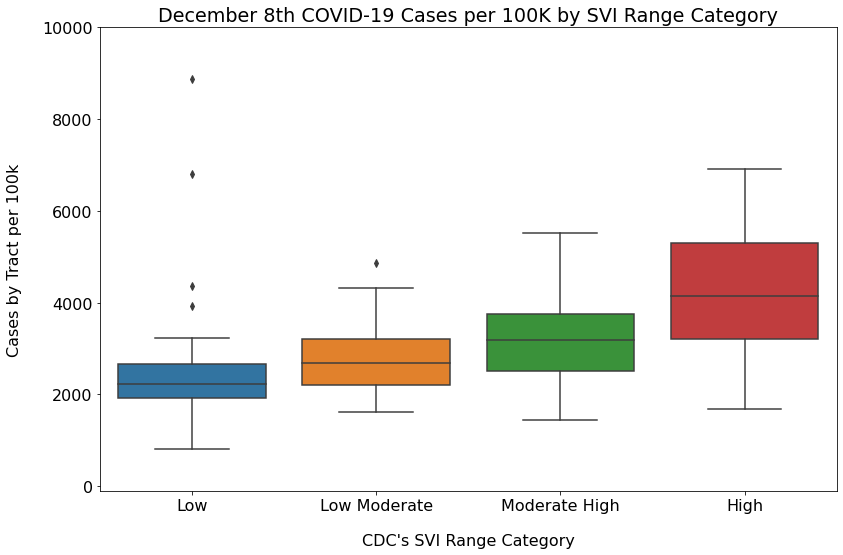

In [3]:
explore.sns_boxplot(train_exp)

**Takeaway:**
`There appears to be a correlation between COVID-19 Count and SVI Category. Next step is Hypothesis testing between categories to validate statistical significance`

In [4]:
# Mean COVID-19 Count By CDC's SVI Category
All = round(train_exp.tract_cases_per_100k.mean(),5)
low = round((train_exp[train_exp.bin_svi == 'Low']).tract_cases_per_100k.mean(),5)
low_mod = round((train_exp[train_exp.bin_svi == 'Low Moderate']).tract_cases_per_100k.mean(),6)
mod_high = round((train_exp[train_exp.bin_svi == 'Moderate High']).tract_cases_per_100k.mean(),6)
high = round((train_exp[train_exp.bin_svi== 'High']).tract_cases_per_100k.mean(),6)

print(f'The average number of cases per 100k for all CDC SVI Range Categories is {All}') 
print(f'The average number of cases per 100k for CDC SVI Range Category (low) is {low}')
print(f'The average number of cases per 100k for CDC SVI Range Category (low_mod) is {low_mod}')
print(f'The average number of cases per 100k for CDC SVI Range Category (mod_high) is {mod_high}')
print(f'The average number of cases per 100k for CDC SVI Range Category (high) is {high}')

The average number of cases per 100k for all CDC SVI Range Categories is 3201.96835
The average number of cases per 100k for CDC SVI Range Category (low) is 2419.21848
The average number of cases per 100k for CDC SVI Range Category (low_mod) is 2705.049127
The average number of cases per 100k for CDC SVI Range Category (mod_high) is 3180.716072
The average number of cases per 100k for CDC SVI Range Category (high) is 4164.339725


In [5]:
low = (train_exp[train_exp.bin_svi == 'Low']).tract_cases_per_100k
low_mod = (train_exp[train_exp.bin_svi == 'Low Moderate']).tract_cases_per_100k
mod_high = (train_exp[train_exp.bin_svi == 'Moderate High']).tract_cases_per_100k
high = (train_exp[train_exp.bin_svi== 'High']).tract_cases_per_100k

#### Variance Test

In [6]:
stats.levene(low, low_mod, mod_high, high)

LeveneResult(statistic=10.327163320383526, pvalue=1.7911798087531878e-06)

In [7]:
alpha = 0.01
null = "Average number of COVID-19 cases per 100k is the same across all CDC SVI Range Categories "
alternate = "Average number of COVID-19 cases per 100k is significantly different across all CDC SVI Range Categories "
explore.anova_test(low, low_mod, mod_high, high, null, alternate, alpha)

f= 43.39597977755902
p= 3.9578566785301897e-23


We reject the null that: 
 Average number of COVID-19 cases per 100k is the same across all CDC SVI Range Categories 


We move forward with the alternative hypothesis that: 
 Average number of COVID-19 cases per 100k is significantly different across all CDC SVI Range Categories 


**Takeaway:**
`We can state with 99% certainty that there is a statistically significant difference between all of the CDC SVI Range Categories`

### Question Two: Is there a correlation between raw_svi and cases per 100k?

In [8]:
raw_svi = train_exp.raw_svi
cases_per_100k = train_exp.tract_cases_per_100k
alpha = 0.01
null = "There is no statistically significant difference betweeen raw_svi and cases per 100K "
alternate = "There is a statistically significant difference betweeen raw_svi and cases per 100K"
explore.pearson(raw_svi, cases_per_100k, null, alternate, alpha)

r= 0.5447686910162987
p= 9.797910801365502e-24


We reject the null that: 
 There is no statistically significant difference betweeen raw_svi and cases per 100K 


We move forward with the alternative hypothesis that: 
 There is a statistically significant difference betweeen raw_svi and cases per 100K


**Takeaway:**
`We can state with 99% certainty that there is not a statistically significant difference between the Social Vulnerability Index and Census Tract cases per 100,000 people.`

## Distribution Exploration

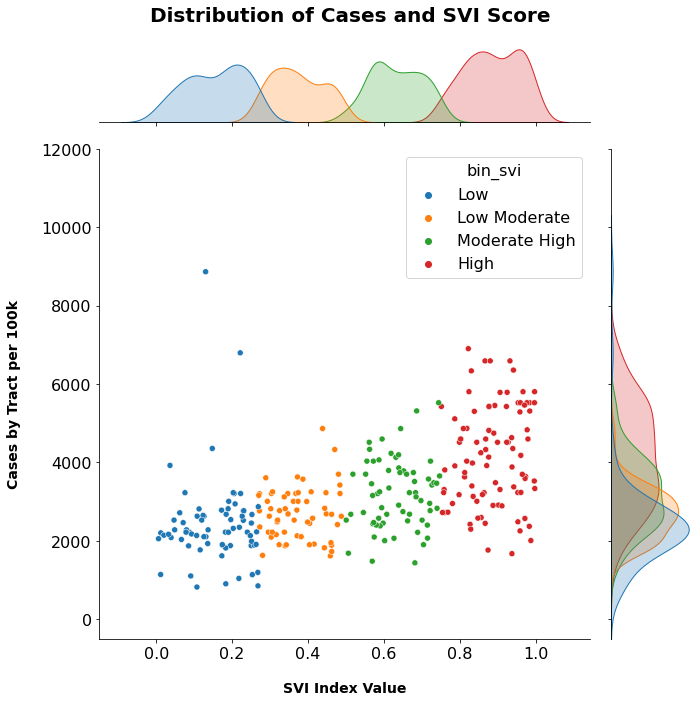

In [9]:
explore.joint_plot_index('raw_svi','tract_cases_per_100k', train_exp, 'bin_svi')

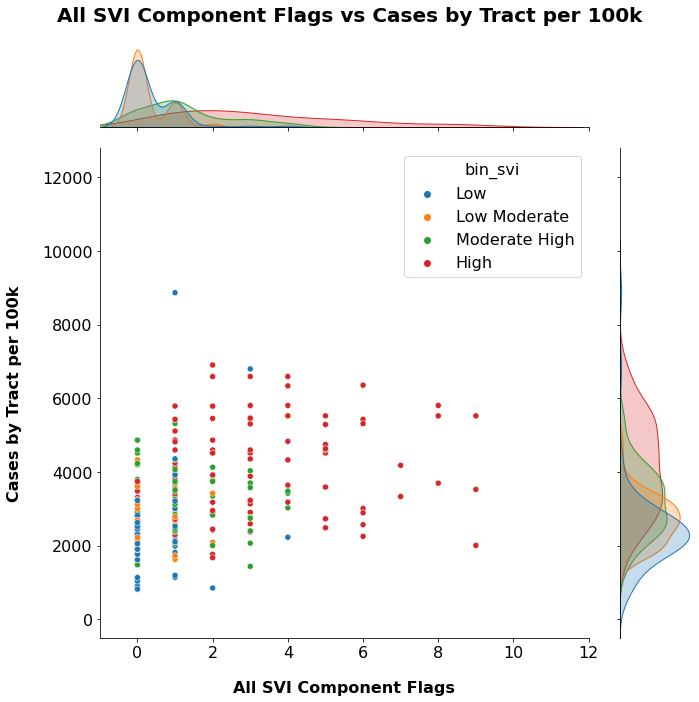

In [10]:
explore.my_plotter(train_exp, "all_flags_total", "All SVI Component Flags", "tract_cases_per_100k", "Cases by Tract per 100k")
plt.show()

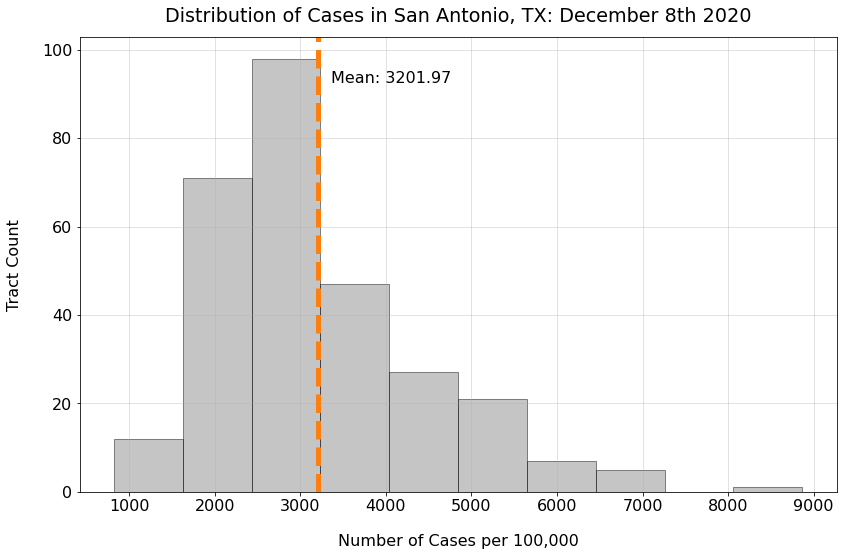

In [11]:
explore.hist_case(train_exp.tract_cases_per_100k)

# Explore: Feature Engineering (Clustering)

Features that demonstrate potential for Clustering

1. E_POV (Persons below poverty estimate)
2. EP_POV (Percentage of persons below poverty estimate)
3. SPL_THEME1 (Sum of series for Socioeconomic theme)

#### Scatterplot spl_theme1


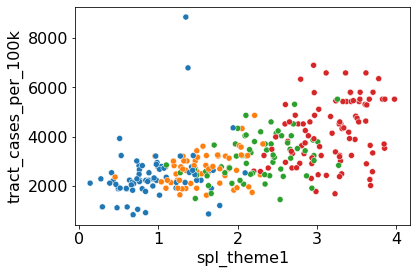

In [12]:
sns.scatterplot(x='spl_theme1', y= 'tract_cases_per_100k',
               data = train_exp, hue='bin_svi',legend = False)
plt.title("")
plt.show()


***

#### Scatterplot e_pov

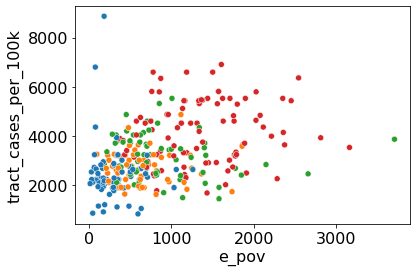

In [13]:
sns.scatterplot(x='e_pov', y= 'tract_cases_per_100k',
               data = train_exp, hue='bin_svi',legend = False)
plt.title("")
plt.show()

***

#### Scatterplot ep_pov

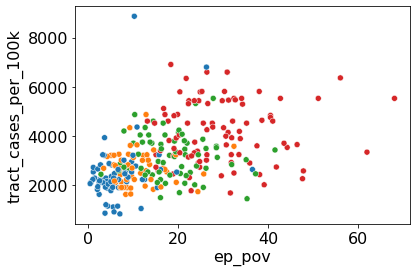

In [14]:
sns.scatterplot(x='ep_pov', y= 'tract_cases_per_100k',
               data = train_exp, hue='bin_svi',legend = False)
plt.title("")
plt.show()

***

## Creating a Poverty Cluster

#### Elbow Method to establish k

   k        sse
0  1  35.748849
1  2  13.654208
2  3   8.691464
3  4   6.753261
4  5   5.757552
5  6   5.077919
6  7   4.495912
7  8   3.967775
8  9   3.568670


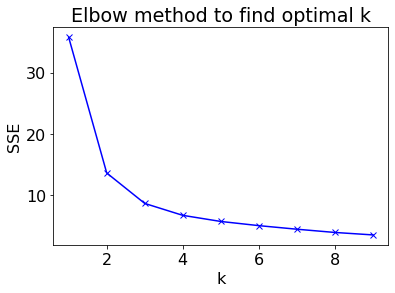

In [15]:
cluster_vars = ['spl_theme1_scaled', 'ep_pov_scaled', 'e_pov_scaled']
explore.elbow_plot(X_train_scaled, cluster_vars)

#### Create Clusters

In [16]:
train_clusters, kmeans = explore.run_kmeans(train_exp, X_train_scaled, k=3, cluster_vars=cluster_vars, cluster_col_name = 'poverty_cluster')
test_clusters = explore.kmeans_transform(X_test_scaled, kmeans, cluster_vars, cluster_col_name = 'poverty_cluster')

#### Get Centroids

In [17]:
centroids = explore.get_centroids(cluster_vars, cluster_col_name='poverty_cluster', kmeans= kmeans)

#### Append Cluster and Join Centroids



In [18]:
train_exp = explore.add_to_train(train_clusters, centroids, train_exp, cluster_col_name = 'poverty_cluster')
X_train_scaled = explore.add_to_train(train_clusters, centroids, X_train_scaled, cluster_col_name = 'poverty_cluster')
X_test_scaled = explore.add_to_train(test_clusters, centroids, X_test_scaled, cluster_col_name = 'poverty_cluster')

In [19]:
X_train_scaled.head(1)

,raw_svi,f_pov_soci,f_unemp_soci,f_pci_soci,f_nohsdp_soci,f_age65_comp,f_age17_comp,f_disabl_comp,f_sngpnt_comp,f_minrty_status,...,f_trans_total_scaled,all_flags_total_scaled,rank_svi_scaled,spl_theme1_scaled,ep_pov_scaled,e_pov_scaled,poverty_cluster,centroid_spl_theme1_scaled,centroid_ep_pov_scaled,centroid_e_pov_scaled
289,0.4879,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.666667,0.314335,0.122963,0.085405,0,0.243449,0.095138,0.096143


## Are the clusters significant?

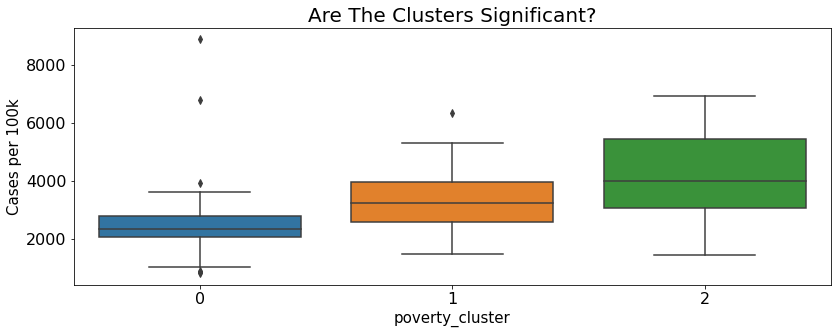

In [20]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.boxplot(train_exp.poverty_cluster, train_exp.tract_cases_per_100k)
plt.xlabel("poverty_cluster", fontsize=15 )
plt.ylabel("Cases per 100k", fontsize=15)
plt.title("Are The Clusters Significant?",fontsize=20)
plt.tight_layout(pad =8)
#plt.ylim(.55,.61)
plt.show()



Hypothesis Testing: (ANOVA/Kruskal)

Is there a statistically significant difference between poverty_clusters and cases per 100k?

Null Hypothesis: Mean # of cases is the same across all clusters

Alternative Hypothesis: Mean # of cases is different across clusters

alpha=0.01


In [21]:
cluster_0 = train_exp[train_exp.poverty_cluster == 0].tract_cases_per_100k
cluster_1 = train_exp[train_exp.poverty_cluster == 1].tract_cases_per_100k
cluster_2 = train_exp[train_exp.poverty_cluster == 2].tract_cases_per_100k

#### Variance Test

In [22]:
stats.levene(cluster_0, cluster_1, cluster_2)

LeveneResult(statistic=16.963064424695425, pvalue=1.0920287239642113e-07)

In [23]:
alpha = 0.01
null = "Mean number of cases per 100k is the same across all clusters"
alternate = "Average number of cases per 100k is significantly different between clusters"
explore.anova_test(low, low_mod, mod_high, high, null, alternate, alpha)

f= 43.39597977755902
p= 3.9578566785301897e-23


We reject the null that: 
 Mean number of cases per 100k is the same across all clusters


We move forward with the alternative hypothesis that: 
 Average number of cases per 100k is significantly different between clusters


#### Split clusters in to dummy variables for modeling

In [24]:
X_train_scaled = pd.get_dummies(X_train_scaled,
                           columns=["poverty_cluster"])
X_test_scaled = pd.get_dummies(X_test_scaled,
                           columns=["poverty_cluster"])

***

# Model the Data

- Baseline for modeling determined by plotting the histogram distribution of COVID-19 cases per 100k.
- The skew observed in the distribution led us to use the median for this value instead of the mean??
- Used cross validation due to limited size of dataset. Size of dataset limited by San Antonio number of census tracts.
- Three of the 4 models used all of the features in the dataset, one model used only the top4 features identified by RFE.
- Linear Regression, LassoLars, and 2 degree polynomial features used all features and a 2nd version of 2 degree polynomial was run with just the top4 features.
- Of these the LassoLars had the least MAE (mean absolute error) and was run on out of sample data (test).
- This model had nearly identical MAE when run on out of sample data, only a 0.7 difference in MAE.
- Overall this is a 25% improvement from mean baseline MAE.

## Create Baseline

In [25]:
# What is the mean vs median of the target variable?
y_train.tract_cases_per_100k.mean(), y_train.tract_cases_per_100k.median()

(3201.968351790576, 2903.7827641596423)

In [26]:
# calculate the mean absolute error (MAE) of the baseline using mean
mean_baseMAE, basepred1 = model_MAE.get_baseline_mean(y_train)

Baseline MAE: 973.0351509141836


## Feature Ranking

- Use recursive feature elimination to evaluate features for modeling

In [27]:
rankdf = model_MAE.feature_ranking(X_train_scaled, y_train)
rankdf

,features
rank,
1,spl_theme1_scaled
2,r_status_fall
3,delta
4,mean
5,rank_svi_scaled
6,f_soci_total_scaled
7,f_pov_soci
8,ep_pov_scaled
9,raw_svi


## Feature Selection

In [28]:
# only raw svi score
X_raw_svi = X_train_scaled[['raw_svi']]
# binned svi score by CDC range category = 1st ranked
X_rank_svi_only = X_train_scaled[['rank_svi_scaled']]
# top 4 ranked features
X_top4 = X_train_scaled[['spl_theme1_scaled', 'r_status_fall', 'delta', 'mean']]
# only the summary of the flags = 19th ranked
X_all_flags_only = X_train_scaled[['all_flags_total_scaled']]
# only summary flags, should be the same as all flags total? = 5th, 12th, 15th, 21st
X_summary_flags = X_train_scaled[['f_comp_total_scaled', 'f_soci_total_scaled', 'f_status_total_scaled', 'f_trans_total_scaled']]
# all individual flags
X_not_summary_flags = X_train_scaled[['f_nohsdp_soci', 'f_minrty_status', 'f_groupq_trans', 'f_unemp_soci', 
                                     'f_disabl_comp', 'f_noveh_trans', 'f_mobile_trans', 'f_age65_comp', 
                                     'f_age17_comp', 'f_pov_soci', 'f_limeng_status', 'f_crowd_trans', 
                                      'f_pci_soci', 'f_sngpnt_comp', 'f_munit_trans']]
# top 10 by RFE
X_top10 = X_train_scaled[['spl_theme1_scaled', 'r_status_fall', 'delta', 'mean', 'rank_svi_scaled', 
                          'f_soci_total_scaled', 'f_pov_soci', 'ep_pov_scaled', 'raw_svi', 'f_age17_comp']]
# engineered features only
X_svifeatures = X_train_scaled[['rising', 'falling', 'delta', 'mean', 'r_soci_rise', 'r_comp_rise', 
                                'r_status_rise', 'r_trans_rise', 'r_soci_fall', 'r_comp_fall', 'r_status_fall', 'r_trans_fall']]
X_Rlist = X_train_scaled[['rank_svi_scaled', 'rising', 'falling', 'delta', 'mean']]

## Build Regression Models

- due to limited size of dataset (limited by number of zip codes in San Antonio area) cross validation will be used for the train and validate stages of modeling
- regression models will be used because the target variable is continuous
- models to try: linear regression, LassoLars, Tweedie Regressor Random Forest Regressor, Support Vector Regressor (SVR)

In [29]:
# create variables for loop
df2test = [X_rank_svi_only, X_top4, X_all_flags_only, X_summary_flags, X_not_summary_flags, X_train_scaled, 
           X_raw_svi, X_top10, X_svifeatures, X_Rlist]
target = y_train

In [30]:
# Linear Regression Models
cvlm_MAE_list = []
for df in df2test:
    cvlm_MAE = model_MAE.cvLinearReg(df, target) 
    cvlm_MAE_list.append(cvlm_MAE)

MAE: 781.251 (723.733)
MAE: 738.457 (730.534)
MAE: 872.290 (741.162)
MAE: 848.118 (733.300)
MAE: 824.294 (728.993)
MAE: 777.084 (730.100)
MAE: 782.547 (718.692)
MAE: 730.765 (700.452)
MAE: 828.639 (730.478)
MAE: 796.571 (699.576)


In [31]:
# LassoLars Models
cvll_MAE_list = []
for df in df2test:
    cvll_MAE = model_MAE.cvLassoLars(df, target, 1) 
    cvll_MAE_list.append(cvll_MAE)

MAE: 782.183 (722.924)
MAE: 735.476 (724.108)
MAE: 874.089 (739.091)
MAE: 847.785 (727.430)
MAE: 819.720 (718.520)
MAE: 758.166 (721.010)
MAE: 782.106 (719.369)
MAE: 725.510 (706.691)
MAE: 818.272 (736.689)
MAE: 794.836 (702.891)


In [32]:
# Random Forest Models
cvrf_MAE_list = []
for df in df2test:
    cvrf_MAE = model_MAE.cvRandomForest(df, target, 4) 
    cvrf_MAE_list.append(cvrf_MAE)

MAE: 789.115 (711.202)
MAE: 867.371 (845.107)
MAE: 886.140 (734.965)
MAE: 864.634 (763.147)
MAE: 814.246 (773.835)
MAE: 851.676 (807.345)
MAE: 970.368 (855.503)
MAE: 865.925 (819.451)
MAE: 861.783 (885.446)
MAE: 896.730 (910.432)


In [33]:
# Tweedie Regressor Models
cvtw_MAE_list = []
for df in df2test:
    cvtw_MAE = model_MAE.cvTweedie(df, target, 1.25, .25)
    cvtw_MAE_list.append(cvtw_MAE)


MAE: 778.155 (716.039)
MAE: 734.922 (761.302)
MAE: 879.435 (757.200)
MAE: 855.047 (752.401)
MAE: 827.712 (759.579)
MAE: 761.408 (752.953)
MAE: 773.678 (717.783)
MAE: 720.793 (745.715)
MAE: 819.661 (753.491)
MAE: 789.614 (699.771)


In [34]:
# Support Vector Models
cvSVRrbf_MAE_list = []
for df in df2test:
    cvSVRrbf_MAE = model_MAE.cvSVR(df, target, 'rbf')
    cvSVRrbf_MAE_list.append(cvSVRrbf_MAE)

MAE: 931.598 (873.853)
MAE: 938.449 (873.997)
MAE: 950.422 (875.754)
MAE: 947.592 (876.159)
MAE: 945.986 (875.699)
MAE: 946.184 (876.076)
MAE: 933.094 (875.387)
MAE: 941.275 (878.109)
MAE: 954.337 (875.567)
MAE: 946.354 (875.928)


In [35]:
# Support Vector Models
cvSVRlinear_MAE_list = []
for df in df2test:
    cvSVRlinear_MAE = model_MAE.cvSVR(df, target, 'linear')
    cvSVRlinear_MAE_list.append(cvSVRlinear_MAE)


MAE: 945.721 (875.750)
MAE: 942.046 (874.593)
MAE: 957.058 (875.437)
MAE: 955.889 (875.657)
MAE: 941.801 (870.728)
MAE: 891.145 (832.464)
MAE: 947.493 (877.127)
MAE: 919.083 (862.828)
MAE: 949.308 (876.481)
MAE: 942.727 (876.684)


### Interpret the Models

In [36]:
# create dataframe for results of all train models
df_list = ['rank_svi_only', 'top4', 'total_all_flags_only', 'summary_flags', 'not_summary_flags', 
           'all_features', 'raw_svi_only', 'top10', 'svi_features', 'Rlist']

results = pd.DataFrame(df_list, columns=['Features'])
results['Base_mean_MAE'] = mean_baseMAE
results['LinearRegression_MAE'] = cvlm_MAE_list
results['LassoLars_MAE'] = cvll_MAE_list
results['Tweedie_MAE'] = cvtw_MAE_list
results['RandomForest_MAE'] = cvrf_MAE_list
results['SVR_rbf_MAE'] = cvSVRrbf_MAE_list
results['SVR_linear_MAE'] = cvSVRlinear_MAE_list
results.sort_values('LinearRegression_MAE')

,Features,Base_mean_MAE,LinearRegression_MAE,LassoLars_MAE,Tweedie_MAE,RandomForest_MAE,SVR_rbf_MAE,SVR_linear_MAE
7,top10,973.035151,730.765130,725.509773,720.792987,865.924609,941.275487,919.082536
1,top4,973.035151,738.457447,735.475548,734.922336,867.371403,938.448679,942.045809
5,all_features,973.035151,777.083574,758.165728,761.408026,851.676230,946.183650,891.145288
0,rank_svi_only,973.035151,781.250760,782.183122,778.154680,789.115123,931.598167,945.721395
6,raw_svi_only,973.035151,782.547295,782.106104,773.677513,970.368056,933.094050,947.493170
9,Rlist,973.035151,796.571146,794.835626,789.613853,896.729646,946.353783,942.727399
4,not_summary_flags,973.035151,824.293633,819.719640,827.711959,814.246281,945.985592,941.801385
8,svi_features,973.035151,828.638600,818.271824,819.660817,861.782813,954.337244,949.308495
3,summary_flags,973.035151,848.117510,847.785452,855.047386,864.633669,947.592445,955.888640
2,total_all_flags_only,973.035151,872.289561,874.089199,879.435482,886.140112,950.421945,957.057820


### Test Stage

In [37]:
# create test dataframe with Top10 features as identified by RFE as that is the best performing model
X_test_top10 = X_test_scaled[['spl_theme1_scaled', 'r_status_fall', 'delta', 'mean', 'rank_svi_scaled', 
                          'f_soci_total_scaled', 'f_pov_soci', 'ep_pov_scaled', 'raw_svi', 'f_age17_comp']]

In [38]:
# fit Linear Regression with Top4 features on train dataset, then use that model to predict test values
TWtestMAE, modelTW = model_MAE.tweedie_test(X_top10, y_train, X_test_top10, y_test, 1.5, .5)
TWtestMAE

814.705154721683

In [39]:
LRtestMAE, modelLR = model_MAE.linear_test(X_top10, y_train, X_test_top10, y_test)
LRtestMAE

851.1850684448569

In [40]:
LLtestMAE, modelLL = model_MAE.lasso_lars_test(X_top10, y_train, X_test_top10, y_test)
LLtestMAE

835.3720267505151

#### Takeaways

- the Top10 performed best on train, but appear to be overfit
- to reduce overfitting will run the Top4 feature model instead

In [41]:
# create test dataframe with only Top4 features as identified by RFE as that is the best performing model
X_test_top4 = X_test_scaled[['spl_theme1_scaled', 'r_status_fall', 'delta', 'mean']]

In [42]:
# fit Linear Regression with Top4 features on train dataset, then use that model to predict test values
TWtestMAE, modelTW = model_MAE.tweedie_test(X_top4, y_train, X_test_top4, y_test, 1.5, .5)
TWtestMAE

767.2785276859596

In [43]:
LRtestMAE, modelLR = model_MAE.linear_test(X_top4, y_train, X_test_top4, y_test)
LRtestMAE

785.8045587970455

In [44]:
LLtestMAE, modelLL = model_MAE.lasso_lars_test(X_top4, y_train, X_test_top4, y_test)
LLtestMAE

780.7786800511973

### Takeaways:
1. Our models successfully beat the baseline.
2. Using the top 4 features (as selected by RFE) Tweedie Regression returned a lower MAE (767 vs 973), Linear Regression returned a lower MAE (785 vs 973) than the baseline, and LassoLars returned a lower MAE (780 vs 973) than the baseline model.
3. Due to this lower error measurement than baseline, we feel confident that our models can be used to effectively predict the graduated need for resources in specific areas in the event of another pandemic.
4. The Tweedie regression model is a 21% improvement over baseline

#### Tweedie regression Summary:

Tweedie is a generalized Linear Model with a Tweedie distribution. The power parameter adjusted the distribution and the alpha parameter determines the regularization strength.


In [45]:
# Tweedie Results table:
tw_result = pd.DataFrame()
x_train_columns = X_test_top4.columns.tolist()
tw_result['features'] = x_train_columns
tw_result['coefs'] = modelTW.coef_
tw_result['abs_coefs'] = abs(modelTW.coef_)
tw_result.sort_values(by = 'abs_coefs', ascending = False).reset_index()

,index,features,coefs,abs_coefs
0,0,spl_theme1_scaled,0.633093,0.633093
1,1,r_status_fall,0.280740,0.280740
2,3,mean,0.212281,0.212281
3,2,delta,-0.179980,0.179980


#### Strengths

- The model demonstrated that the SVI does a good job of predicting in San Antonio the areas that were most at risk from the COVID infections. Interestingly enough, those areas most at risk from natural disasters (such as hurricanes, fires, and other acts of nature) the communities needing resources in response to a pandemic within San Antonio appear to be highly correlated to the overall SVI score.
- Looking inside the Index itself and reviewing the component parts, we discovered that socioeconomic "flags" or components tended to be a stronger correlation than other types of components of the overall Social Vulnerability Index.


#### Weaknesses

- There is no consensus in research literature as to which components of the SVI have the strongest correlation to health risks or outcomes. There are some demographic groups requiring careful interpretation of the results due to their unique characteristics.
- These models are not intended in any way to be presented as predictions of infection; the medical reasons for COVID transmission are still as yet undetermined, and would require a vastly more complex model than is presented here. The purpose of this model was to measure and predict those areas most in need of help and response from communities and local officials. 

## Build Classification Models

In [46]:
# bring in classification datasets with new y variable
class_df, class_train_exp, class_X_train_scaled, class_y_train, class_X_test_scaled, class_y_test = wrangle.wrangle_data_class()

Acquire: compiling raw data files...
Acquire: Completed!
Prepare: preparing data files...
Prepare: Completed!
(289, 42) (73, 42)
wrangle_class.py functions successfully loaded


In [47]:
# only raw svi score
cX_raw_svi = class_X_train_scaled[['raw_svi']]
# binned svi score by CDC range category = 1st ranked
cX_rank_svi_only = class_X_train_scaled[['rank_svi_scaled']]
# top 4 ranked features
cX_top4 = class_X_train_scaled[['spl_theme1_scaled', 'r_status_fall', 'delta', 'mean']]
# only the summary of the flags = 19th ranked
cX_all_flags_only = class_X_train_scaled[['all_flags_total_scaled']]
# only summary flags, should be the same as all flags total? = 5th, 12th, 15th, 21st
cX_summary_flags = class_X_train_scaled[['f_comp_total_scaled', 'f_soci_total_scaled', 'f_status_total_scaled', 'f_trans_total_scaled']]
# all individual flags
cX_not_summary_flags = class_X_train_scaled[['f_nohsdp_soci', 'f_minrty_status', 'f_groupq_trans', 'f_unemp_soci', 
                                     'f_disabl_comp', 'f_noveh_trans', 'f_mobile_trans', 'f_age65_comp', 
                                     'f_age17_comp', 'f_pov_soci', 'f_limeng_status', 'f_crowd_trans', 
                                      'f_pci_soci', 'f_sngpnt_comp', 'f_munit_trans']]
# top 10 by RFE
cX_top10 = class_X_train_scaled[['spl_theme1_scaled', 'r_status_fall', 'delta', 'mean', 'rank_svi_scaled', 
                          'f_soci_total_scaled', 'f_pov_soci', 'ep_pov_scaled', 'raw_svi', 'f_age17_comp']]
# engineered features only
cX_svifeatures = class_X_train_scaled[['rising', 'falling', 'delta', 'mean', 'r_soci_rise', 'r_comp_rise', 
                                'r_status_rise', 'r_trans_rise', 'r_soci_fall', 'r_comp_fall', 'r_status_fall', 'r_trans_fall']]
cX_Rlist = class_X_train_scaled[['rank_svi_scaled', 'rising', 'falling', 'delta', 'mean']]

In [48]:
# create variables for loop
cdf2test = [cX_rank_svi_only, cX_top4, cX_all_flags_only, cX_summary_flags, cX_not_summary_flags, class_X_train_scaled, 
           cX_raw_svi, cX_top10, cX_svifeatures, cX_Rlist]
ctarget = class_y_train

In [49]:
class_y_train.rank_cases.value_counts()

3    141
2     85
1     53
4     10
Name: rank_cases, dtype: int64

<AxesSubplot:ylabel='Frequency'>

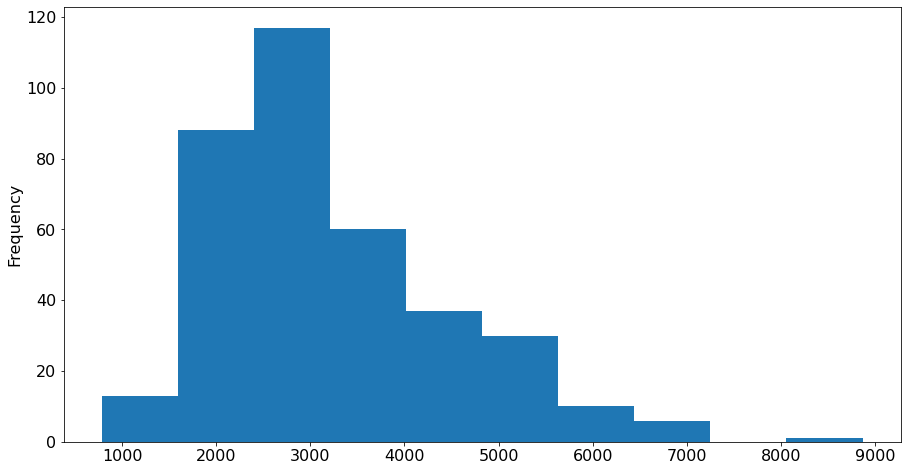

In [50]:
class_df.tract_cases_per_100k.plot(kind = 'hist')

In [51]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [52]:
import model_classification

In [53]:
model_classification.random_forest_class(cX_raw_svi, ctarget, max_depth = 4, n_estimators = 200)

RF CV scores mean: 0.68
Accuracy of Random Forest Model on training set: 0.66


Array of cross validation scores:


array([0.66603908, 0.7428442 , 0.75569358, 0.65297619, 0.63630952,
       0.57103175, 0.65491071, 0.65649802, 0.80699405, 0.68469827])

In [54]:
model_classification.random_forest_class(class_X_train_scaled, ctarget, max_depth = 4, n_estimators = 200)

RF CV scores mean: 0.74
Accuracy of Random Forest Model on training set: 0.70


Array of cross validation scores:


array([0.83476967, 0.73955745, 0.7614648 , 0.70744048, 0.66061508,
       0.67619048, 0.70684524, 0.64801587, 0.90982143, 0.74422385])

In [55]:
model_classification.random_forest_class(cX_Rlist, ctarget, 4)

RF CV scores mean: 0.71
Accuracy of Random Forest Model on training set: 0.66


Array of cross validation scores:


array([0.78206522, 0.72339545, 0.75775104, 0.67628968, 0.68452381,
       0.58412698, 0.65595238, 0.63670635, 0.8110119 , 0.7761381 ])

In [56]:
# create variables for loop
crf2test = [
            cX_rank_svi_only, 
            cX_top4, 
            cX_all_flags_only, 
            cX_summary_flags, 
            cX_not_summary_flags, 
            class_X_train_scaled, 
            cX_raw_svi, 
            cX_top10, 
            cX_svifeatures, 
            cX_Rlist
           ]
# target var:
ctarget = class_y_train


# Random Forest Models Classification Loop
cvrf_class_list = []
for df in crf2test:
    cvrf_class = model_classification.random_forest_class(df, target, 3) 
    cvrf_class_list.append(cvrf_class)

ValueError: Unknown label type: 'continuous'

In [ ]:
# Random Forest Models Classification Loop
cvrf_class_list = []
for df in df2test:
    cvrf_class = model_classification.random_forest_class(df, target, 3) 
    cvrf_class_list.append(cvrf_class)

# Next Steps: What Can We Do Now?

## Is San Antonio different from other cities?


- San Antonio is very different from Dallas
- SVI and features do seem to correlate closely with high case rates in San Antonio

## Feature Engineering

- SVI trend for the county
    - is rising? is declining? 
    - delta of SVI change year over year?
    - std dev of SVI?

- This is an area for possible further exploration